In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Pre-processing was needed even before we load the data. Following steps were performed:

- Organising directory : some students had uploaded facial data of two or more people in the same folder, so separating them.
- Some students had also put multiple celebrities photo under the same class so filtering them out.
- Two students had also uplaoded the exact same images so removed them so that it prevents one class from having double the number of photos that too duplicated.
- Filtering out .gif and .webp files so that all images have standard .jpg , .jpeg , or .png extensions.
- Finally renaming pictures to not have special characters such as '&' in their names as it was causing error while uploading in kaggle

### Finally we have our data having 26 classes each having around 90-110 images. Let's load the dataset and perform further pre-processing

In [1]:
# pip install mtcnn
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.3 MB/s eta 0:00:0000:0100:01


In [2]:
import os
from tqdm import tqdm
from PIL import Image
from torchvision import transforms, datasets
from facenet_pytorch import MTCNN
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

## EXTRACTING FACES

In [39]:
device='cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(keep_all=True, device=device)

# Define input and output directories
input_dir = '/kaggle/input/facial-data-advml/Facial Data'  # Update with your dataset path
output_dir = '/kaggle/working/face_images'  # Output directory to store face images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


In [4]:
# Function to extract face images from each folder
def extract_faces(input_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    count=0
    # Loop through images in the input folder
    for image_file in tqdm(os.listdir(input_folder)):
        try:
            if image_file.endswith('.pdf'):
                print(f"Skipping PDF file: {image_file}")
                count+=1
                continue
                
            # Load image
            image_path = os.path.join(input_folder, image_file)
            img = Image.open(image_path).convert('RGB')
            
            # Detect faces
            faces = mtcnn(img)
            
            if faces is not None:
           # Save detected faces
                for i, face in enumerate(faces):
                    # Convert the PyTorch tensor to a PIL Image
                    face_pil = transforms.ToPILImage()(face)

                    # Save the face image
                    face_path = os.path.join(output_folder, f'{image_file[:-4]}_{i}.jpg')
                    face_pil.save(face_path)
            else:
                print(f"Skipping {image_file} because no face found")
                count+=1
                
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
            
    print('====================================')
    print(f"Skipped {count} images in total for face not found/.pdf extension in {input_folder} folder")
    print('====================================')


In [ ]:
for class_folder in os.listdir(input_dir):
    input_class_folder = os.path.join(input_dir, class_folder)
    output_class_folder = os.path.join(output_dir, class_folder)
    
    # Extract faces for each class
    extract_faces(input_class_folder, output_class_folder)

## Now that we have the extracted faces, I saved them and created another dataset in kaggle so that i can now directly work with extracted faces instead of repeating the extraction process everytime I run the notebook

In [5]:
dataset_dir = '/kaggle/input/extracted-faces/face_images'
class_counts = {}

# Iterate over each class folder in the dataset directory
for class_folder in os.listdir(dataset_dir):
    if os.path.isdir(os.path.join(dataset_dir, class_folder)):
        # Count the number of face images in the class folder
        num_images = len(os.listdir(os.path.join(dataset_dir, class_folder)))
        class_counts[class_folder] = num_images


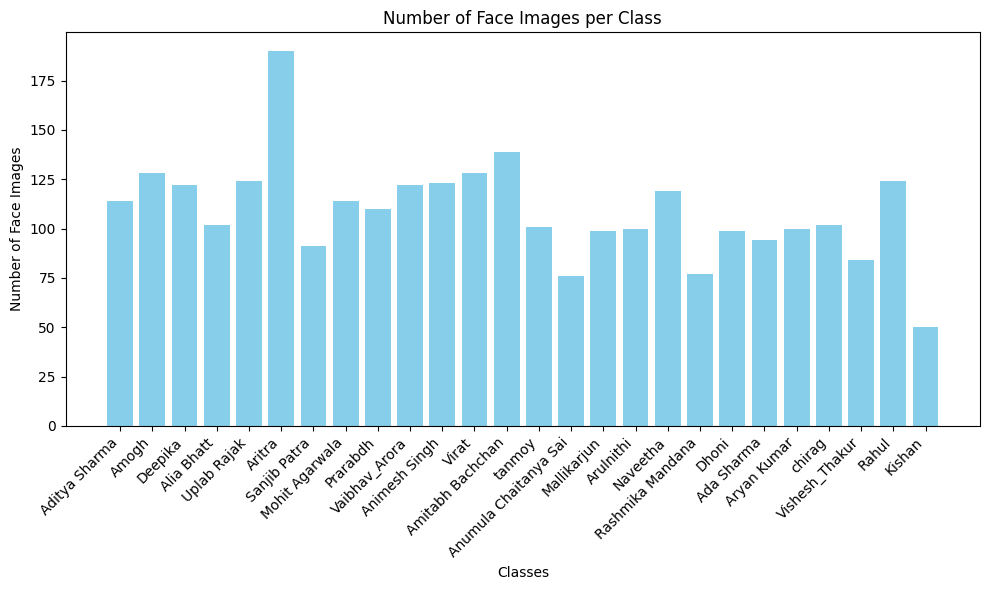

In [6]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Face Images')
plt.title('Number of Face Images per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
widths = []
heights = []

# Iterate over each class folder in the dataset directory
for class_folder in os.listdir(dataset_dir):
    if os.path.isdir(os.path.join(dataset_dir, class_folder)):
        # Iterate over each image in the class folder
        for image_file in os.listdir(os.path.join(dataset_dir, class_folder)):
            image_path = os.path.join(dataset_dir, class_folder, image_file)
            # Get the dimensions of the image
            with Image.open(image_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)

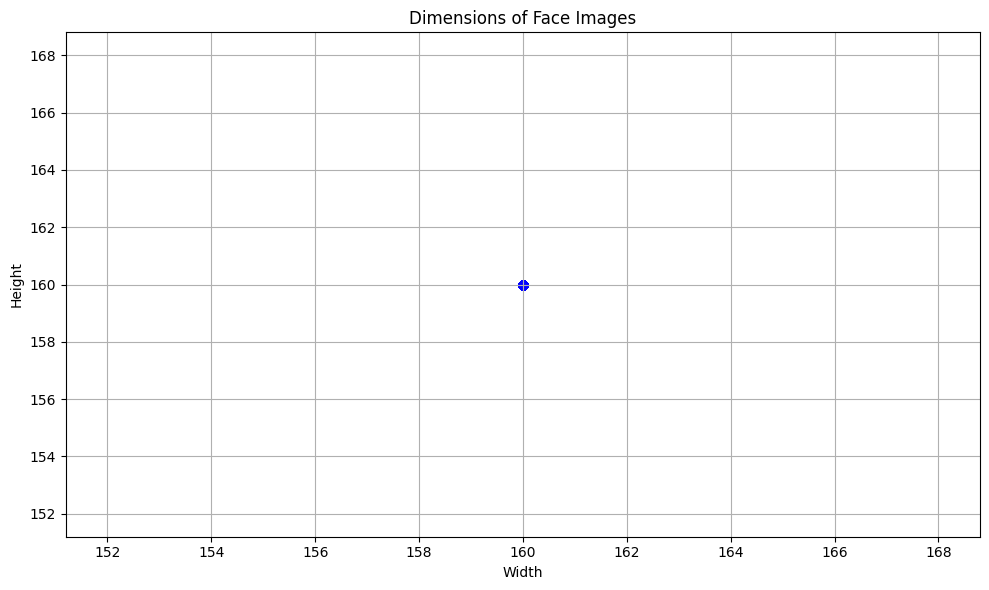

In [8]:
# Plotting the curve
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', alpha=0.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Dimensions of Face Images')
plt.grid(True)
plt.tight_layout()
plt.show()

## SINCE HEIGHT AND WIDTH ARE SAME AFTER EXTRACTING FACES, NO NEED OF RESIZING, JUST NORMALIZING AND BASIC AUGMENTATIONS TO THE IMAGE IS PREFORMED

In [34]:
# Define normalization transformation
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

# Define augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(160, 160), scale=(0.8, 1.0), ratio=(0.9, 1.1))
])

# Combined transformation for training dataset (including normalization and augmentation)
train_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
    augmentation_transforms
])


## SPLITTING INTO TRAIN, VAL AND TEST DATASETS

In [42]:
full_dataset = datasets.ImageFolder(dataset_dir, transform=train_transform)

# Define the sizes for train, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Create data loaders for train, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## CNN MODEL DEFINITION

In [43]:
class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 128 * 10 * 10)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## TRAINING WITH VALIDATION along with learning rate scheduler to help the model converge faster

In [45]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0  
        train_total = 0    
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        
        train_loss = running_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = val_correct / val_total
        val_loss = val_running_loss / len(val_loader.dataset)  # Compute validation loss
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}")
        
        # Update the learning rate scheduler
        scheduler.step(val_loss)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

# Train the model with the scheduler
train(model, train_loader, val_loader, criterion, optimizer, scheduler, 20)


Epoch 1/20, Train Loss: 3.084150540012924, Training Accuracy: 0.11876379690949228, Validation Accuracy: 0.34275618374558303, Validation Loss: 2.407972415849935
Epoch 2/20, Train Loss: 2.029602496671361, Training Accuracy: 0.44900662251655626, Validation Accuracy: 0.5406360424028268, Validation Loss: 1.7882191839993211
Epoch 3/20, Train Loss: 1.4702094985949283, Training Accuracy: 0.5814569536423841, Validation Accuracy: 0.6395759717314488, Validation Loss: 1.3301010485672697
Epoch 4/20, Train Loss: 1.1913528432909226, Training Accuracy: 0.6560706401766004, Validation Accuracy: 0.6501766784452296, Validation Loss: 1.195137387029695
Epoch 5/20, Train Loss: 0.981074150166501, Training Accuracy: 0.708167770419426, Validation Accuracy: 0.6219081272084805, Validation Loss: 1.254244705181661
Epoch 6/20, Train Loss: 0.852161613626459, Training Accuracy: 0.7492273730684327, Validation Accuracy: 0.6996466431095406, Validation Loss: 1.1505009346631727
Epoch 7/20, Train Loss: 0.724989112270852, Tr

## FINAL VALIDATION ACCURACY ACHIEVED WAS 77 %

In [48]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    
test(model, test_loader, criterion)


Test Loss: 0.2853907560798484, Test Accuracy: 0.9330985915492958


## FINAL TEST ACCURACY WAS 90% (WOAH)

## this is just for checking dimensions to resolve errors

In [ ]:
# Check dimensions of images in train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print("Image dimensions:", images.shape)
    # Print the dimensions of the first image in the batch
    print("First image dimensions:", images[0].shape)
    break  # Exit the loop after checking the first batch


## Saving for later use

In [ ]:
model_path = '/kaggle/working/cnn1.pth'

# Save the model
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

## TESTING PIPELINE ALONG WITH THRESHOLD ON CONFIDENCE SCORES TO DETECT UNKNOWN FACES

In [22]:
data_dir = '/kaggle/input/facial-data-advml/Facial Data'
class_names = sorted(os.listdir(data_dir))
class_mapping = {str(i): class_name for i, class_name in enumerate(class_names)}

# Define function for testing a single face image
def test_face_image(model, face_image_path, threshold=0.7):
    face_image = Image.open(face_image_path)
    input_image = preprocess(face_image).unsqueeze(0)  # Add batch dimension

    if torch.cuda.is_available():
        input_image = input_image.cuda()

    model.eval()
    with torch.no_grad():
        output = model(input_image)
    probabilities = torch.softmax(output, dim=1)

    # Get the maximum probability and its corresponding index
    max_probability, predicted_index = torch.max(probabilities, 1)
    confidence_score = max_probability.item()
    
    # Check if the maximum probability is above the threshold
    if confidence_score > threshold:
        predicted_label = predicted_index.item()
        predicted_class_name = class_mapping.get(str(predicted_label), 'Unknown')
        
    else:
        predicted_class_name = 'Unknown'

    return predicted_class_name, confidence_score

In [23]:
def extract_faces_from_test(test_image_path, output_folder):
    # Create output folder for extracted face from test image
    os.makedirs(output_folder, exist_ok=True)
    
    try:
        img = Image.open(test_image_path).convert('RGB')
        faces = mtcnn(img)

        if faces is not None:
            for i, face in enumerate(faces):
                face_pil = transforms.ToPILImage()(face)
                face_path = os.path.join(output_folder, f'face_{i}.jpg')
                face_pil.save(face_path)
                break
        else:
            print(f"No face found in {test_image_path}")

    except Exception as e:
        print(f"Error processing {test_image_path}: {e}")



In [24]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
# Define function for testing pipeline with face extraction
def test_face_pipeline(model, test_image_path):
    # Extract faces from test image
    faces_output_folder = '/kaggle/working/test_faces'
    extract_faces_from_test(test_image_path, faces_output_folder)

    # Perform inference on each extracted face
    for face_image_file in os.listdir(faces_output_folder):
        face_image_path = os.path.join(faces_output_folder, face_image_file)
        predicted_label = test_face_image(model, face_image_path)
        print(f"Predicted label for {face_image_file}: {predicted_label}")

Model loaded from /kaggle/input/cnn1-minor-project-advml/cnn1.pth


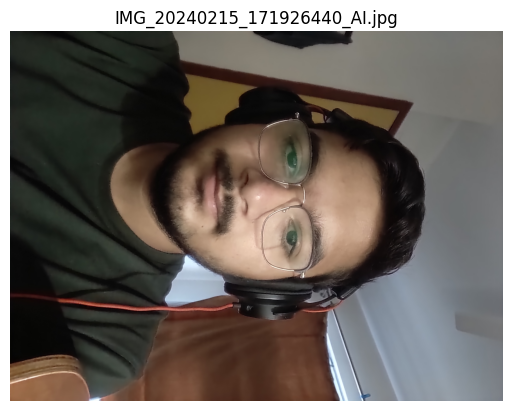

Predicted label for face_0.jpg: ('Amitabh Bachchan', 0.9300246238708496)


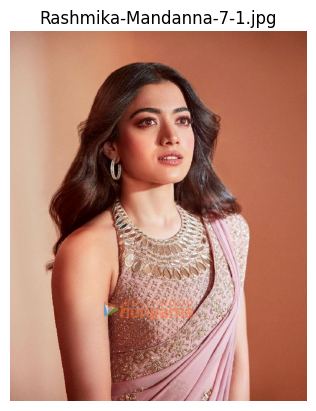

Predicted label for face_0.jpg: ('Rashmika Mandana', 0.9710148572921753)


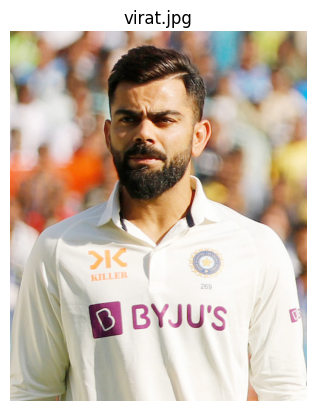

Predicted label for face_0.jpg: ('Unknown', 0.7928494215011597)


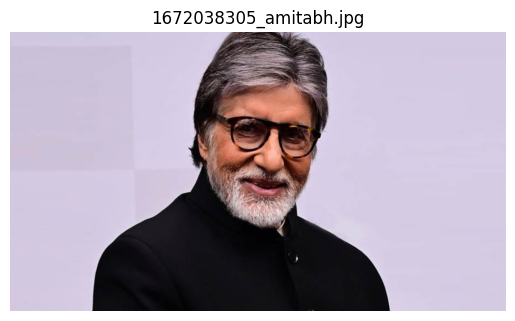

Predicted label for face_0.jpg: ('Amitabh Bachchan', 0.9999992847442627)


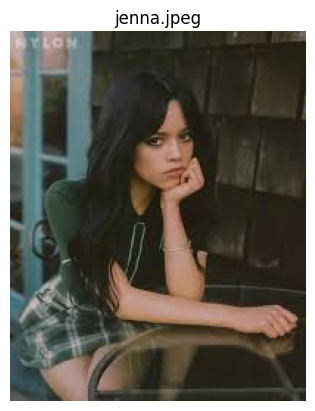

Predicted label for face_0.jpg: ('Unknown', 0.7258138060569763)


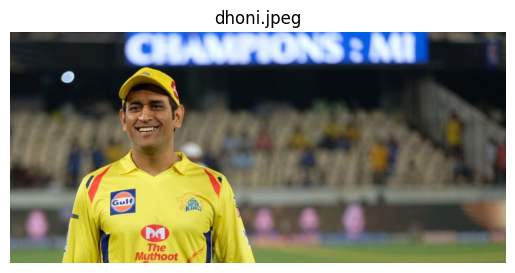

Predicted label for face_0.jpg: ('Dhoni', 0.9991464614868164)


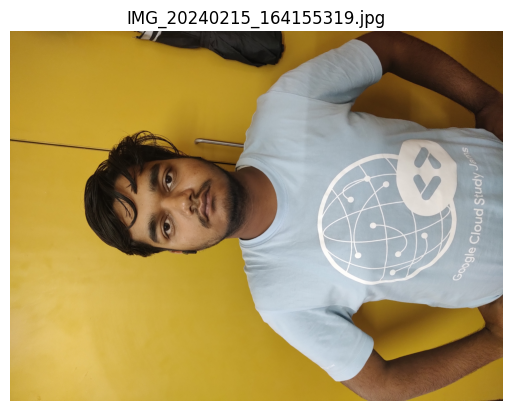

Predicted label for face_0.jpg: ('Unknown', 0.711952805519104)


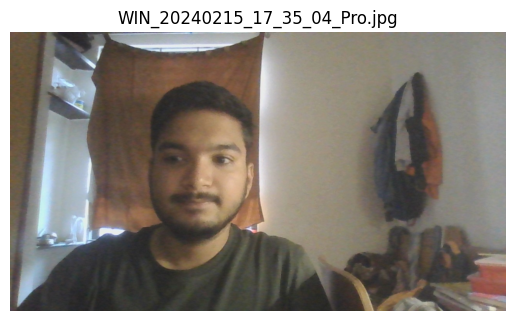

Predicted label for face_0.jpg: ('Animesh Singh', 0.9218279123306274)


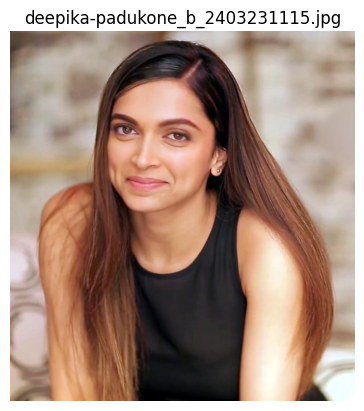

Predicted label for face_0.jpg: ('Deepika', 0.9363996386528015)


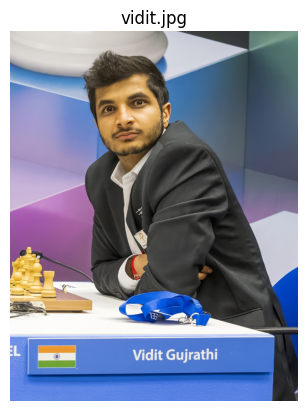

Predicted label for face_0.jpg: ('Unknown', 0.39033567905426025)


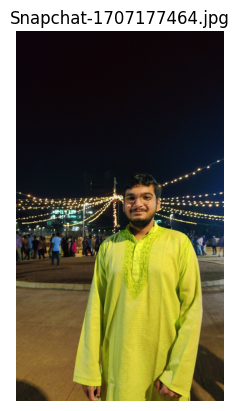

Predicted label for face_0.jpg: ('Animesh Singh', 0.9910887479782104)


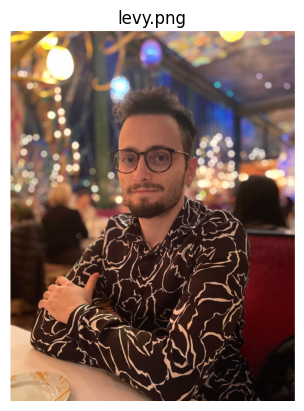

Predicted label for face_0.jpg: ('Unknown', 0.6785398721694946)


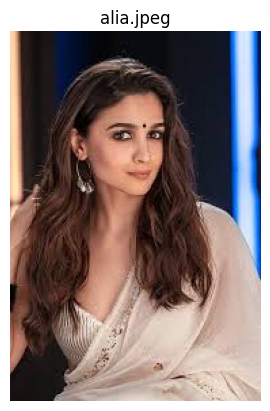

Predicted label for face_0.jpg: ('Alia Bhatt', 0.9998067021369934)


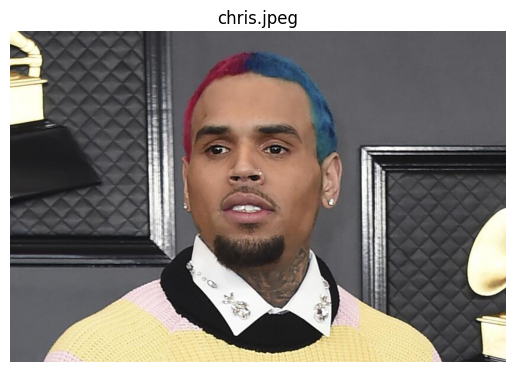

Predicted label for face_0.jpg: ('Sanjib Patra', 0.8423947095870972)


In [47]:
# Define the file path from which you want to load the model
model_path = '/kaggle/input/cnn1-minor-project-advml/cnn1.pth'
model = CNN()
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"Model loaded from {model_path}")

if torch.cuda.is_available():
    model = model.cuda()

# Define the folder path containing the test images
test_images_folder = '/kaggle/input/sample-test/'

# Iterate over all files in the folder
for filename in os.listdir(test_images_folder):
    # Construct the full path to the image file
    image_path = os.path.join(test_images_folder, filename)
    
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(filename)
    plt.axis('off')
    plt.show()
    
    # Run the testing pipeline for each image
    test_face_pipeline(model, image_path)


## As you can see although the model is not correct all the time, it is performing decent. I also tested on random face images above , it is classifying most of them as unknown

# below code is just for deleting directory created in kaggle working directory and is no longer needed

In [ ]:
# import shutil

# # Define the directory path to be deleted
# directory_path = '/kaggle/working/test_faces'

# # Delete the directory and all its contents
# shutil.rmtree(directory_path)

# print(f"Directory {directory_path} and its contents have been deleted.")
